Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-cifar10.ipynb)

## Code Modules, Classes & Functions

In [0]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn as tnn
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() 
                 else "cpu")

In [0]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [0]:
class LeNN5(tnn.Module):
    def __init__(self,num_classes,grayscale=False):
        super(LeNN5,self).__init__()        
        self.grayscale=grayscale
        self.num_classes=num_classes
        if self.grayscale: in_channels=1
        else: in_channels=3
        self.features=tnn.Sequential(            
            tnn.Conv2d(in_channels,6*in_channels,
                       kernel_size=5),
            tnn.Tanh(),
            tnn.MaxPool2d(kernel_size=2),
            tnn.Conv2d(6*in_channels,16*in_channels,
                       kernel_size=5),
            tnn.Tanh(),
            tnn.MaxPool2d(kernel_size=2))
        self.classifier=tnn.Sequential(
            tnn.Linear(16*5*5*in_channels,120*in_channels),
            tnn.Tanh(),
            tnn.Linear(120*in_channels,84*in_channels),
            tnn.Tanh(),
            tnn.Linear(84*in_channels,num_classes),)
    def forward(self, x):
        x=self.features(x)
        x=torch.flatten(x,1)
        logits=self.classifier(x)
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

In [0]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def display_examples(data_loader):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(32,32,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes,num_examples):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),
          end='^')

In [0]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev)
            targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%300:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))           
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
                  (epoch+1,epochs,model_acc(model,train_loader)))
@register_line_magic
def print_acc(t):
    if t=='test':
        print('Test accuracy: %.4f%%'%\
        (model_acc(model,test_loader)))
    if t=='train':
        print('Train accuracy: %.4f%%'%\
        (model_acc(model,train_loader)))

In [0]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev)
            targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%300:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))           
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
                  (epoch+1,epochs,model_acc(model,train_loader2)))
@register_line_magic
def print_acc2(t):
    if t=='test':
        print('Test accuracy: %.4f%%'%\
        (model_acc(model,test_loader2)))
    if t=='train':
        print('Train accuracy: %.4f%%'%\
        (model_acc(model,train_loader2)))

## Data

In [0]:
random_seed=12; batch_size=128
tr0=(.5,.5,.5)
transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train=tcifar10(root='data',train=True,download=True,
               transform=transform)
test=tcifar10(root='data',train=False, 
              transform=transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Files already downloaded and verified


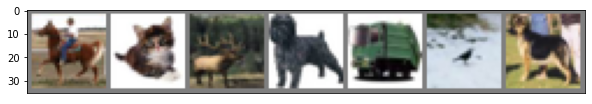

    horse^      cat^     deer^      dog^    truck^     bird^      dog^

In [0]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(train_loader,classes,7)

In [0]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
x=x.reshape(-1,3,32,32)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_train=x[:n],x[n:]
y_test,y_train=y[:n],y[n:]
x_train.shape,y_train.shape

['backgrounds', 'images', 'labels']


((11352, 3, 32, 32), (11352,))

Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


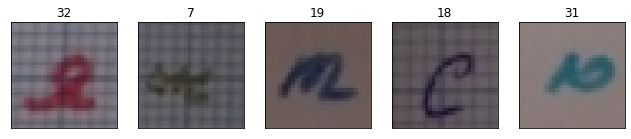

In [0]:
random_seed=1; batch_size2=128
train2=TData(x_train,y_train)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,batch_size=batch_size2,shuffle=False)
display_examples(train_loader2)

## LeNet 5 Training

In [0]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.001
model=LeNN5(num_classes,False)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate) 

In [0]:
%train_run 15

Epoch: 001/015 | Batch 000/390 | Cost: 2.3064
Epoch: 001/015 | Batch 300/390 | Cost: 1.3080
Epoch: 001/015 train accuracy: 58.79%
Epoch: 002/015 | Batch 000/390 | Cost: 1.2796
Epoch: 002/015 | Batch 300/390 | Cost: 1.0801
Epoch: 002/015 train accuracy: 63.72%
Epoch: 003/015 | Batch 000/390 | Cost: 1.0009
Epoch: 003/015 | Batch 300/390 | Cost: 0.9313
Epoch: 003/015 train accuracy: 69.61%
Epoch: 004/015 | Batch 000/390 | Cost: 0.9516
Epoch: 004/015 | Batch 300/390 | Cost: 0.6833
Epoch: 004/015 train accuracy: 74.01%
Epoch: 005/015 | Batch 000/390 | Cost: 0.8935
Epoch: 005/015 | Batch 300/390 | Cost: 0.7736
Epoch: 005/015 train accuracy: 78.45%
Epoch: 006/015 | Batch 000/390 | Cost: 0.5407
Epoch: 006/015 | Batch 300/390 | Cost: 0.5969
Epoch: 006/015 train accuracy: 83.24%
Epoch: 007/015 | Batch 000/390 | Cost: 0.6015
Epoch: 007/015 | Batch 300/390 | Cost: 0.5651
Epoch: 007/015 train accuracy: 87.26%
Epoch: 008/015 | Batch 000/390 | Cost: 0.3021
Epoch: 008/015 | Batch 300/390 | Cost: 0.391

In [0]:
%print_acc train
%print_acc test

Train accuracy: 97.5460%
Test accuracy: 66.0700%


In [0]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.001
model=LeNN5(num_classes,False)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [0]:
%train_run2 15

Epoch: 001/015 | Batch 000/088 | Cost: 3.4956
Epoch: 001/015 train accuracy: 11.13%
Epoch: 002/015 | Batch 000/088 | Cost: 3.1358
Epoch: 002/015 train accuracy: 25.32%
Epoch: 003/015 | Batch 000/088 | Cost: 2.6800
Epoch: 003/015 train accuracy: 33.57%
Epoch: 004/015 | Batch 000/088 | Cost: 2.3665
Epoch: 004/015 train accuracy: 41.83%
Epoch: 005/015 | Batch 000/088 | Cost: 2.2186
Epoch: 005/015 train accuracy: 49.90%
Epoch: 006/015 | Batch 000/088 | Cost: 1.8290
Epoch: 006/015 train accuracy: 53.59%
Epoch: 007/015 | Batch 000/088 | Cost: 1.6520
Epoch: 007/015 train accuracy: 58.56%
Epoch: 008/015 | Batch 000/088 | Cost: 1.5395
Epoch: 008/015 train accuracy: 61.80%
Epoch: 009/015 | Batch 000/088 | Cost: 1.2968
Epoch: 009/015 train accuracy: 64.65%
Epoch: 010/015 | Batch 000/088 | Cost: 1.2067
Epoch: 010/015 train accuracy: 69.55%
Epoch: 011/015 | Batch 000/088 | Cost: 1.0872
Epoch: 011/015 train accuracy: 73.59%
Epoch: 012/015 | Batch 000/088 | Cost: 1.0405
Epoch: 012/015 train accuracy:

In [0]:
%print_acc2 train
%print_acc2 test

Train accuracy: 81.8710%
Test accuracy: 65.2572%
